In [1]:
%config Completer.use_jedi = False

In [11]:
import numpy as np
import gym
from collections import deque
import random
import torch.autograd
import os
import math
import time
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F 
from torch.autograd import Variable
import sys
import pickle
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import matplotlib.markers as markers
import pybullet as p 
if torch.cuda.is_available() and False:
    device = torch.device("cuda:0")  # you can continue going on here, like cuda:1 cuda:2....etc. 
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")
import networkx as nx
from tqdm import tqdm
import dgl
import morphsim as m
from graphenvs import HalfCheetahGraphEnv
import itertools

%matplotlib notebook

Running on the CPU


In [3]:
class NetworkInverseDynamics(nn.Module):
    def __init__(
        self,
        input_size,
        output_size,
        hidden_sizes,
        with_batch_norm=False,
        activation=None
    ):
        super(NetworkInverseDynamics, self).__init__()
        self.hidden_sizes = hidden_sizes
        self.input_size = input_size
        self.output_size = output_size
        
        self.layers = nn.ModuleList()

        self.layers.append(nn.Linear(self.input_size, hidden_sizes[0]))
        if with_batch_norm:
            self.layers.append(nn.LayerNorm(normalized_shape=(hidden_sizes[0])))
        self.layers.append(nn.ReLU())
        
        for i in range(len(hidden_sizes) - 1):
            self.layers.append(nn.Linear(hidden_sizes[i], hidden_sizes[i+1]))
            if with_batch_norm:
                self.layers.append(nn.LayerNorm(normalized_shape=(hidden_sizes[i+1])))
            self.layers.append(nn.ReLU())
        
        self.layers.append(nn.Linear(hidden_sizes[len(hidden_sizes) - 1], self.output_size))
        
        if activation is not None:
            self.layers.append(activation())
            
    def forward(self, x):
        out = x
        
        for layer in self.layers:
            out = layer(out)
            
        return out


In [4]:
class GNNInverseDynamics(nn.Module):
    def __init__(
        self,
        inputNetwork,
        messageNetwork,
        updateNetwork,
        outputNetwork,
        numMessagePassingIterations,
        withInputNetwork = True
    ):
        
        super(GNNInverseDynamics, self).__init__()
                
        self.inputNetwork = inputNetwork
        self.messageNetwork = messageNetwork
        self.updateNetwork = updateNetwork
        self.outputNetwork = outputNetwork
        
        self.numMessagePassingIterations = numMessagePassingIterations
        self.withInputNetwork = withInputNetwork
        
    def inputFunction(self, nodes):
        return {'state' : self.inputNetwork(nodes.data['input'])}
    
    def messageFunction(self, edges):
        
        batchSize = edges.src['state'].shape[1]
        edgeData = edges.data['feature'].repeat(batchSize, 1).T.unsqueeze(-1)
        nodeInput = edges.src['input']
        
        return {'m' : self.messageNetwork(torch.cat((edges.src['state'], edgeData, nodeInput), -1))}
    
    def updateFunction(self, nodes):
        return {'state': self.updateNetwork(torch.cat((nodes.data['m_hat'], nodes.data['state']), -1))}
    
    def outputFunction(self, nodes):
        
        return {'output': self.outputNetwork(nodes.data['state'])}


    def forward(self, graph, state):
        
        self.update_states_in_graph(graph, state)
        
        if self.withInputNetwork:
            graph.apply_nodes(self.inputFunction)
        
        for messagePassingIteration in range(self.numMessagePassingIterations):
            graph.update_all(self.messageFunction, dgl.function.mean('m', 'm_hat'), self.updateFunction)
        
        graph.apply_nodes(self.outputFunction)
        
        output = graph.ndata['output']
        output = output.squeeze(-1).mean(0)
                
        return output
    
    def update_states_in_graph(self, graph, state):
        if len(state.shape) == 1:
            state = state.unsqueeze(0)
        
        numGraphFeature = 6
        numGlobalStateInformation = 5
        numLocalStateInformation = 2
        numStateVar = state.shape[1] // 2
        globalInformation = torch.cat((state[:, 0:5], state[:, numStateVar:numStateVar+5]), -1)
        
        numNodes = (numStateVar - 5) // 2

        nodeData = torch.empty((numNodes, state.shape[0], numGraphFeature + 2 * numGlobalStateInformation + 2 * numLocalStateInformation)).to(device)
        for nodeIdx in range(numNodes):

            # Assign global features from graph
            nodeData[nodeIdx, :, :6] = graph.ndata['feature'][nodeIdx]
            # Assign local state information
            nodeData[nodeIdx, :, 16] = state[:, 5 + nodeIdx]
            nodeData[nodeIdx, :, 17] = state[:, 5 + numNodes + nodeIdx]
            nodeData[nodeIdx, :, 18] = state[:, numStateVar + 5 + nodeIdx]
            nodeData[nodeIdx, :, 19] = state[:, numStateVar + 5 + numNodes + nodeIdx]

        # Assdign global state information
        nodeData[:, :, 6:16] = globalInformation
        
        if self.withInputNetwork:
            graph.ndata['input'] = nodeData        
        
        else:
            graph.ndata['state'] = nodeData


In [5]:
class NetworkAutoEncoder(nn.Module):
    def __init__(
        self,
        input_size,
        output_size,
        hidden_sizes,
        batch_size=256, # Needed only for batch norm
        with_batch_norm=False,
        activation=None
    ):
        super(NetworkAutoEncoder, self).__init__()
        self.hidden_sizes = hidden_sizes
        self.input_size = input_size
        self.output_size = output_size
        
        self.layers = nn.ModuleList()

        self.layers.append(nn.Linear(self.input_size, hidden_sizes[0]))
        if with_batch_norm:
#             self.layers.append(nn.BatchNorm1d(batch_size))
            self.layers.append(nn.LayerNorm(normalized_shape=(hidden_sizes[0])))
        self.layers.append(nn.ReLU())
        
        for i in range(len(hidden_sizes) - 1):
            self.layers.append(nn.Linear(hidden_sizes[i], hidden_sizes[i+1]))
            if with_batch_norm:
#                 self.layers.append(nn.BatchNorm1d(batch_size))
                self.layers.append(nn.LayerNorm(normalized_shape=(hidden_sizes[i+1])))
            self.layers.append(nn.ReLU())
        
        self.layers.append(nn.Linear(hidden_sizes[len(hidden_sizes) - 1], self.output_size))
        
        if activation is not None:
            self.layers.append(activation())
            
    def forward(self, x):
        out = x
        
        for layer in self.layers:
            out = layer(out)
            
        return out

In [6]:
class GraphNeuralNetworkAutoEncoder(nn.Module):
    def __init__(
            self,
            inputNetwork,
            messageNetwork,
            updateNetwork,
            outputNetwork,
            numMessagePassingIterations,
            encoder=True
    ):

        super(GraphNeuralNetworkAutoEncoder, self).__init__()

        self.inputNetwork = inputNetwork
        self.messageNetwork = messageNetwork
        self.updateNetwork = updateNetwork
        self.outputNetwork = outputNetwork

        self.numMessagePassingIterations = numMessagePassingIterations
        self.encoder = encoder

    def inputFunction(self, nodes):
        return {'state': self.inputNetwork(nodes.data['input'])}

    def messageFunction(self, edges):

        batchSize = edges.src['state'].shape[1]
        edgeData = edges.data['feature'].repeat(batchSize, 1).T.unsqueeze(-1)
        nodeInput = edges.src['input']

        #         print(edges.src['state'].shape)
        #         print(nodeInput.shape)
        return {'m': self.messageNetwork(torch.cat((edges.src['state'], edgeData, nodeInput), -1))}

    def updateFunction(self, nodes):
        return {'state': self.updateNetwork(torch.cat((nodes.data['m_hat'], nodes.data['state']), -1))}

    def outputFunction(self, nodes):

        #         numNodes, batchSize, stateSize = graph.ndata['state'].shape
        #         return self.outputNetwork.forward(graph.ndata['state'])
        return {'output': self.outputNetwork(nodes.data['state'])}

    def forward(self, graph, state):

        self.update_states_in_graph(graph, state)

        graph.apply_nodes(self.inputFunction)

        for messagePassingIteration in range(self.numMessagePassingIterations):
            graph.update_all(self.messageFunction, dgl.function.max('m', 'm_hat'), self.updateFunction)

        graph.apply_nodes(self.outputFunction)

        output = graph.ndata['output']

        if self.encoder:
            output = F.normalize(output, dim=-1)

        return output

    def update_states_in_graph(self, graph, state):

        if self.encoder:
            if len(state.shape) == 1:
                state = state.unsqueeze(0)

            numGraphFeature = 6
            numGlobalStateInformation = 5
            numLocalStateInformation = 2
            numStateVar = state.shape[1]
            globalInformation = state[:, 0:5]
            batch_size = state.shape[0]
            numNodes = (numStateVar - 5) // 2

            nodeData = torch.empty(
                (numNodes, batch_size, numGraphFeature + numGlobalStateInformation + numLocalStateInformation)).to(
                device)

            nodeData[:, :, 0:numGlobalStateInformation] = globalInformation
            for nodeIdx in range(numNodes):
                # Assign local state information
                nodeData[nodeIdx, :, numGlobalStateInformation] = state[:, 5 + nodeIdx]
                nodeData[nodeIdx, :, numGlobalStateInformation + 1] = state[:, 5 + numNodes + nodeIdx]
                # Assign global features from graph
                nodeData[nodeIdx, :, numGlobalStateInformation + 2: numGlobalStateInformation + 2 + numGraphFeature] = \
                graph.ndata['feature'][nodeIdx]

            graph.ndata['input'] = nodeData

        else:
            numNodes, batchSize, inputSize = state.shape
            nodeData = torch.empty((numNodes, batchSize, inputSize + 6)).to(device)
            nodeData[:, :, :inputSize] = state
            nodeData[:, :, inputSize: inputSize + 6] = graph.ndata['feature'].unsqueeze(dim=1).repeat_interleave(
                batchSize, dim=1)
            #             for nodeIdx in range(numNodes):
            #                 nodeData[nodeIdx, :, inputSize : inputSize + 6] = graph.ndata['feature'][nodeIdx]

            graph.ndata['input'] = nodeData

In [7]:
states = {}
actions = {}
rewards = {}
next_states = {}
dones = {}
env = {}

for morphIdx in [5]:

    prefix = '../datasets/{}/'.format(morphIdx)
    
    states[morphIdx] = np.load(prefix + 'states_array.npy')
    actions[morphIdx] = np.load(prefix + 'actions_array.npy')
    rewards[morphIdx] = np.load(prefix + 'rewards_array.npy')
    next_states[morphIdx] = np.load(prefix + 'next_states_array.npy')
    dones[morphIdx] = np.load(prefix + 'dones_array.npy')
    
    env[morphIdx] = HalfCheetahGraphEnv(None)
    env[morphIdx].set_morphology(morphIdx)
    env[morphIdx].reset()

None
*************************************************************************************************************


/home/ovi/anaconda3/envs/honors-project/lib/python3.8/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
NoneType: None


In [8]:
hidden_sizes = [256, 256]

inputSize = 13
stateSize = 64
messageSize = 64
latentSize = 3
numMessagePassingIterations = 6
batch_size = 1024
numBatchesPerTrainingStep = 1
minRandomDistance = 1
maxSequentialDistance = 0.04
with_batch_norm = True

# # Encoder Networks
encoderInputNetwork = NetworkAutoEncoder(inputSize, stateSize, hidden_sizes, with_batch_norm=with_batch_norm)
encoderMessageNetwork = NetworkAutoEncoder(stateSize + inputSize + 1, messageSize, hidden_sizes, with_batch_norm=with_batch_norm, activation=nn.Tanh)
encoderUpdateNetwork = NetworkAutoEncoder(stateSize + messageSize, stateSize, hidden_sizes, with_batch_norm=with_batch_norm)
encoderOutputNetwork = NetworkAutoEncoder(stateSize, latentSize, hidden_sizes, with_batch_norm=with_batch_norm)
encoderGNN = GraphNeuralNetworkAutoEncoder(encoderInputNetwork, encoderMessageNetwork, encoderUpdateNetwork, encoderOutputNetwork, numMessagePassingIterations, encoder=True).to(device)

# # Decoder Networks
decoderInputNetwork = NetworkAutoEncoder(latentSize + 6, stateSize, hidden_sizes, with_batch_norm=with_batch_norm)
decoderMessageNetwork = NetworkAutoEncoder(stateSize + latentSize + 7, messageSize, hidden_sizes, with_batch_norm=with_batch_norm, activation=nn.Tanh)
decoderUpdateNetwork = NetworkAutoEncoder(stateSize + messageSize, stateSize, hidden_sizes, with_batch_norm=with_batch_norm)
decoderOutputNetwork = NetworkAutoEncoder(stateSize, 7, hidden_sizes, with_batch_norm=with_batch_norm)
decoderGNN = GraphNeuralNetworkAutoEncoder(decoderInputNetwork, decoderMessageNetwork, decoderUpdateNetwork, decoderOutputNetwork, numMessagePassingIterations, encoder=False).to(device)

# encoderGNN.load_state_dict(torch.load('../models/new/4-latent-single-GNN-AutoEncoder/5/0.0-1.5/encoderGNN.pt'))
# decoderGNN.load_state_dict(torch.load('../models/new/4-latent-single-GNN-AutoEncoder/5/0.0-1.5/decoderGNN.pt'))

print(encoderGNN.load_state_dict(torch.load('../models/new/3-latent-single-GNN-AutoEncoder/5/0.0-1.33/' + 'encoderGNN.pt')))
print(decoderGNN.load_state_dict(torch.load('../models/new/3-latent-single-GNN-AutoEncoder/5/0.0-1.33/' + 'decoderGNN.pt')))


# encoderGNN.load_state_dict(torch.load('../models/new/3-latent-single-GNN-AutoEncoder/5/0.0-1.0/encoderGNN.pt'))
# decoderGNN.load_state_dict(torch.load('../models/new/3-latent-single-GNN-AutoEncoder/5/0.0-1.0/decoderGNN.pt'))

# encoderGNN.load_state_dict(torch.load('../models/GNN-AutoEncoder/multi-GNN-2-latent-contrastive/encoderGNN.pt'))
# decoderGNN.load_state_dict(torch.load('../models/GNN-AutoEncoder/multi-GNN-2-latent-contrastive/decoderGNN.pt'))

# encoderGNN.load_state_dict(torch.load('../models/new/single-GNN-AutoEncoder/5/0.1-0.4/encoderGNN.pt'))
# decoderGNN.load_state_dict(torch.load('../models/new/single-GNN-AutoEncoder/5/0.1-0.4/decoderGNN.pt'))

<All keys matched successfully>
<All keys matched successfully>


In [12]:
hidden_sizes = [256, 256]

inputSize = 20
stateSize = 64
messageSize = 64
outputSize = 1
numMessagePassingIterations = 6
batch_size = 2048
with_batch_norm = True
numBatchesPerTrainingStep = 1

inputNetwork = NetworkInverseDynamics(inputSize, stateSize, hidden_sizes, with_batch_norm)
messageNetwork = NetworkInverseDynamics(stateSize + inputSize + 1, messageSize, hidden_sizes, with_batch_norm, nn.Tanh)
updateNetwork = NetworkInverseDynamics(stateSize + messageSize, stateSize, hidden_sizes, with_batch_norm)
outputNetwork = NetworkInverseDynamics(stateSize, outputSize, hidden_sizes, with_batch_norm, nn.Sigmoid)

inverseDynamics = GNNInverseDynamics(inputNetwork, messageNetwork, updateNetwork, outputNetwork, numMessagePassingIterations)
inverseDynamics.load_state_dict(torch.load('mixed-delta-validTransition.pt'))

<All keys matched successfully>

In [13]:
def reconstructStateFromGraph(graph_data):
    num_nodes, batch_size, data_size = graph_data.shape
    output = torch.empty((batch_size, 5 + 2 * num_nodes))
    output[:, :5] = graph_data[:, :, :5].mean(dim=0)
    output[:, 5::2] = graph_data[:, :, 5].T
    output[:, 6::2] = graph_data[:, :, 6].T
    
    return output

In [31]:
num_samples = 2048

morphIdx = 5
g = env[morphIdx].get_graph()._get_dgl_graph().cpu()
num_nodes = g.num_nodes()

next_states_encodings = torch.empty((num_nodes, num_samples, 2))
xs = torch.from_numpy(np.linspace(-1, 1, num=num_samples // 2)[np.newaxis, ...], ).to(torch.float32).repeat(num_nodes, 1)
ys = torch.sqrt(1 - xs ** 2)
next_states_encodings[:, : num_samples // 2, 0] = xs
next_states_encodings[:, num_samples // 2 : , 0] = xs
next_states_encodings[:, :num_samples // 2 , 1] = ys
next_states_encodings[:, num_samples // 2: , 1] = -ys

In [12]:
next_states = decoderGNN(g, next_states_encodings).to('cpu').detach()
next_states = reconstructStateFromGraph(next_states)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (14336x8 and 10x256)

In [ ]:
# num_velocity_samples = 1024
# velocity_changed_states = torch.zeros(num_velocity_samples, state_size * 2)
# velocity_changed_states[:, :state_size] = next_states[random_idx].repeat(num_velocity_samples, 1)
# velocity_changed_states[:, state_size] = torch.from_numpy(np.linspace(start=-0.1, stop=3, num=num_velocity_samples))
# g = env[morphIdx].get_graph()._get_dgl_graph().cpu()
# velocity_changed_sigmoids = inverseDynamics(g, velocity_changed_states)
# g = env[morphIdx].get_graph()._get_dgl_graph().cpu()
# velocity_changed_encodings = encoderGNN(g, velocity_changed_states[:, state_size:])

# print(velocity_changed_sigmoids.mean())
# print(velocity_changed_sigmoids.min())
# print(velocity_changed_sigmoids.max())
# print(velocity_changed_sigmoids.std())

In [ ]:
state_space = states[morphIdx][0].shape[0]
offsets = torch.from_numpy(np.random.normal(size=(num_samples, state_space)))

In [56]:
random_idx = np.random.choice(next_states.shape[0])
state_size = next_states.shape[1]
uniformly_sampled_states = next_states[random_idx].repeat(num_samples, 2)
uniformly_sampled_states[:, state_size:] -= next_states
g = env[morphIdx].get_graph()._get_dgl_graph().cpu()
uniformly_sampled_sigmoids = inverseDynamics(g, uniformly_sampled_states)

x = next_states_encodings[0, :, 0].numpy()
y = next_states_encodings[0, :, 1].numpy()
c = uniformly_sampled_sigmoids.cpu().detach().numpy()

cmap = 'jet'

plt.scatter(x, y, c=c, cmap=cmap)
plt.scatter(next_states_encodings[:, random_idx, 0], next_states_encodings[:, random_idx, 1], c='red', marker='x', s=80)

normalize = mcolors.Normalize(vmin=c.min(), vmax=c.max())
scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=cmap)
scalarmappaple.set_array(c)
plt.colorbar(scalarmappaple)
plt.savefig('latest.png')

plt.show()

(7, 2048, 2)
Num valid transitions 20/2048


<IPython.core.display.Javascript object>


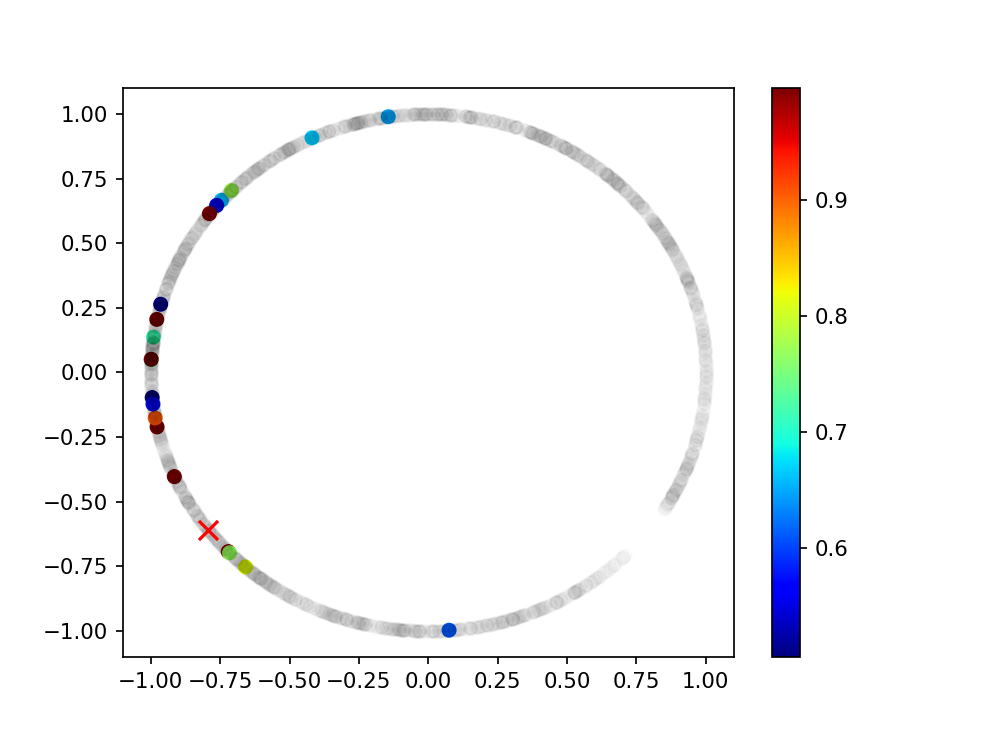

In [117]:
morphIdx = 5
state_size = states[morphIdx].shape[-1]
g = env[morphIdx].get_graph()._get_dgl_graph().cpu()


num_comparison_states = 2048
# comparison_states = torch.from_numpy(states[morphIdx][:num_comparison_states]).to(torch.float32)
comparison_states_indeces = np.random.choice(np.arange(900000), size=num_comparison_states, replace=False)
comparison_states = torch.from_numpy(states[morphIdx][comparison_states_indeces])
encodings = encoderGNN(g, comparison_states).detach().cpu().numpy()
print(encodings.shape)
random_idx = np.random.choice(np.arange(num_comparison_states))
randomly_chosen_state = comparison_states[random_idx]
state_pairs = randomly_chosen_state.unsqueeze(0).repeat(num_comparison_states, 2)
state_pairs[:,  state_size:] -= comparison_states
prediction_sigmoids = inverseDynamics(g, state_pairs).detach().cpu().numpy()

indeces_to_keep = prediction_sigmoids > 0.5
prediction_sigmoids = prediction_sigmoids[indeces_to_keep]
origin_point = encodings[:, random_idx]
kept_encodings = encodings[:, indeces_to_keep]

print('Num valid transitions {}/{}'.format(np.sum((prediction_sigmoids > 0.5)),  num_comparison_states))

x = kept_encodings[0, :, 0]
y = kept_encodings[0, :, 1]
c = prediction_sigmoids
cmap = 'jet'

plt.scatter(x, y, c=c, cmap=cmap)
plt.scatter(encodings[0, :, 0], encodings[0, :, 1], c='black', alpha=0.01)
plt.scatter(origin_point[0, 0],  origin_point[0, 1],  c='red', marker='x', s=80)

normalize = mcolors.Normalize(vmin=c.min(), vmax=c.max())
scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=cmap)
scalarmappaple.set_array(c)
plt.colorbar(scalarmappaple)

plt.savefig('randomly-sampled-from-dataset.png')
plt.show()
# fig = plt.figure() 
# ax = plt.axes(projection ='3d') 
# ax.scatter3D(x, y, np.arange(x.shape[0]), alpha=0.7)

Num valid transitions 9/1000


<IPython.core.display.Javascript object>


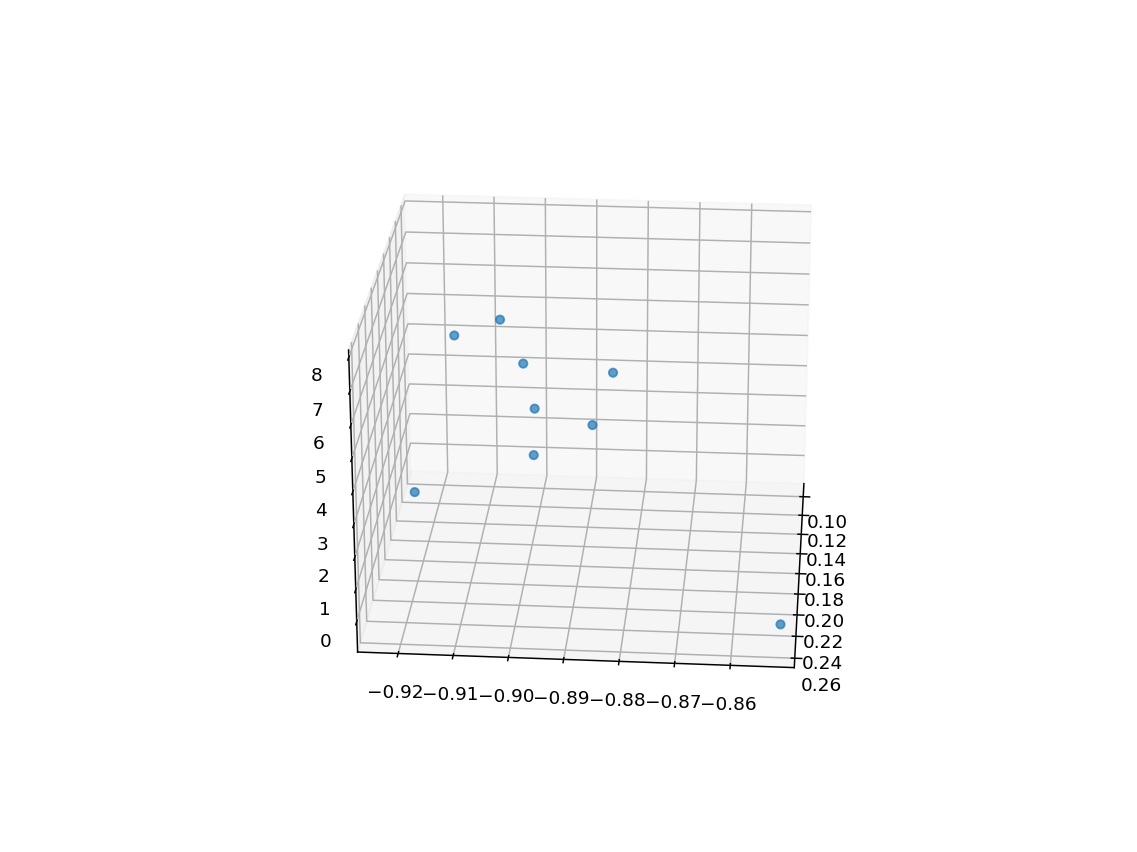

In [33]:
morphIdx = 5
state_size = states[morphIdx].shape[-1]
g = env[morphIdx].get_graph()._get_dgl_graph().cpu()

episode_idx = 2
episode_states = torch.from_numpy(states[morphIdx][episode_idx * 1000: (episode_idx+1) * 1000])
encodings = encoderGNN(g, episode_states).detach().cpu().numpy()


random_idx = np.random.choice(np.arange(1000))
randomly_chosen_state = episode_states[random_idx]
state_pairs = randomly_chosen_state.unsqueeze(0).repeat(1000, 2)
state_pairs[:,  state_size:] -= episode_states
prediction_sigmoids = inverseDynamics(g, state_pairs).detach().cpu().numpy()

indeces_to_keep = prediction_sigmoids > 0.5
prediction_sigmoids = prediction_sigmoids[indeces_to_keep]
origin_point = encodings[:, random_idx]
kept_encodings = encodings[:, indeces_to_keep]

print('Num valid transitions {}/{}'.format(np.sum((prediction_sigmoids > 0.5)),  1000))

x = kept_encodings[0, :, 0]
y = kept_encodings[0, :, 1]
z = kept_encodings[0, :, 2]

c = prediction_sigmoids
cmap = 'jet'

# plt.scatter(x, y, c=c, cmap=cmap)
# plt.scatter(encodings[0, :, 0], encodings[0, :, 1], c='black', alpha=0.01)
# plt.scatter(origin_point[0, 0],  origin_point[0, 1],  c='red', marker='x', s=80)

# normalize = mcolors.Normalize(vmin=c.min(), vmax=c.max())
# scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=cmap)
# scalarmappaple.set_array(c)
# plt.colorbar(scalarmappaple)

# plt.savefig('sampled-from-episode.png')
# plt.show()
fig = plt.figure() 
ax = plt.axes(projection ='3d') 
ax.scatter3D(x, y, np.arange(x.shape[0]), alpha=0.7)

(7, 1000, 3)
Num valid transitions 7/1000
tensor([0.2793, 0.1508, 0.3991, 0.4033, 0.3339, 0.2218, 0.1975])


<IPython.core.display.Javascript object>


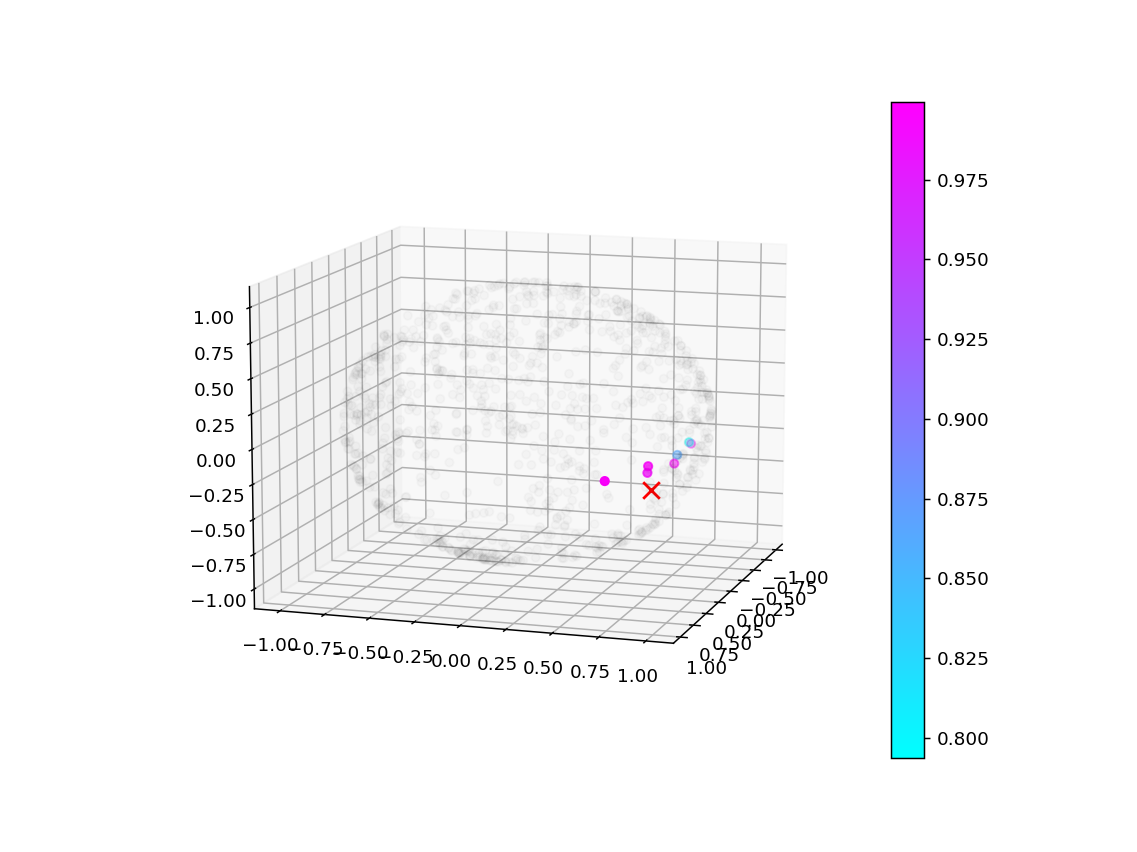

In [17]:
# Transition Probability Visualization with 3 latent variables

morphIdx = 5
state_size = states[morphIdx].shape[-1]
g = env[morphIdx].get_graph()._get_dgl_graph().cpu()


num_comparison_states = 1000
comparison_states = torch.from_numpy(states[morphIdx][:num_comparison_states]).to(torch.float32)
# comparison_states_indeces = np.random.choice(np.arange(900000), size=num_comparison_states, replace=False)
# comparison_states = torch.from_numpy(states[morphIdx][comparison_states_indeces])
encodings = encoderGNN(g, comparison_states).detach().cpu().numpy()
print(encodings.shape)
random_idx = np.random.choice(np.arange(num_comparison_states))
randomly_chosen_state = comparison_states[random_idx]
state_pairs = randomly_chosen_state.unsqueeze(0).repeat(num_comparison_states, 2)
state_pairs[:,  state_size:] -= comparison_states
prediction_sigmoids = inverseDynamics(g, state_pairs).detach().cpu().numpy()

indeces_to_keep = prediction_sigmoids > 0.5
prediction_sigmoids = prediction_sigmoids[indeces_to_keep]
origin_point = encodings[:, random_idx]
kept_encodings = encodings[:, indeces_to_keep]

print('Num valid transitions {}/{}'.format(np.sum((prediction_sigmoids > 0.5)),  num_comparison_states))

encoding_differences = torch.from_numpy(kept_encodings[0] - origin_point[0])
print(torch.norm(encoding_differences, p=2, dim=-1))

fig = plt.figure() 
ax = plt.axes(projection ='3d') 

x = kept_encodings[0, :, 0]
y = kept_encodings[0, :, 1]
z = kept_encodings[0, :, 2]

c = prediction_sigmoids

cmap = 'cool'

ax.scatter3D(x, y, z, c=c, cmap=cmap)
ax.scatter3D(encodings[0, :, 0], encodings[0, :, 1], encodings[0, :, 2], c='black', alpha=0.02)
ax.scatter3D(origin_point[0, 0],  origin_point[0, 1], origin_point[0, 2], c='red', marker='x', s=80)

normalize = mcolors.Normalize(vmin=c.min(), vmax=c.max())
scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=cmap)
scalarmappaple.set_array(c)
plt.colorbar(scalarmappaple)

plt.show()
# ax.view_init(elev=0, azim=45)
# fig.savefig('3d-transition-latentVis-1.png')

# ax.view_init(elev=30, azim=90)
# fig.savefig('3d-transition-latentVis-2.png')

# ax.view_init(elev=15, azim=0)
# fig.savefig('3d-transition-latentVis-3.png')

# ax.view_init(elev=90, azim=0)
# fig.savefig('3d-transition-latentVis-4.png')

<IPython.core.display.Javascript object>


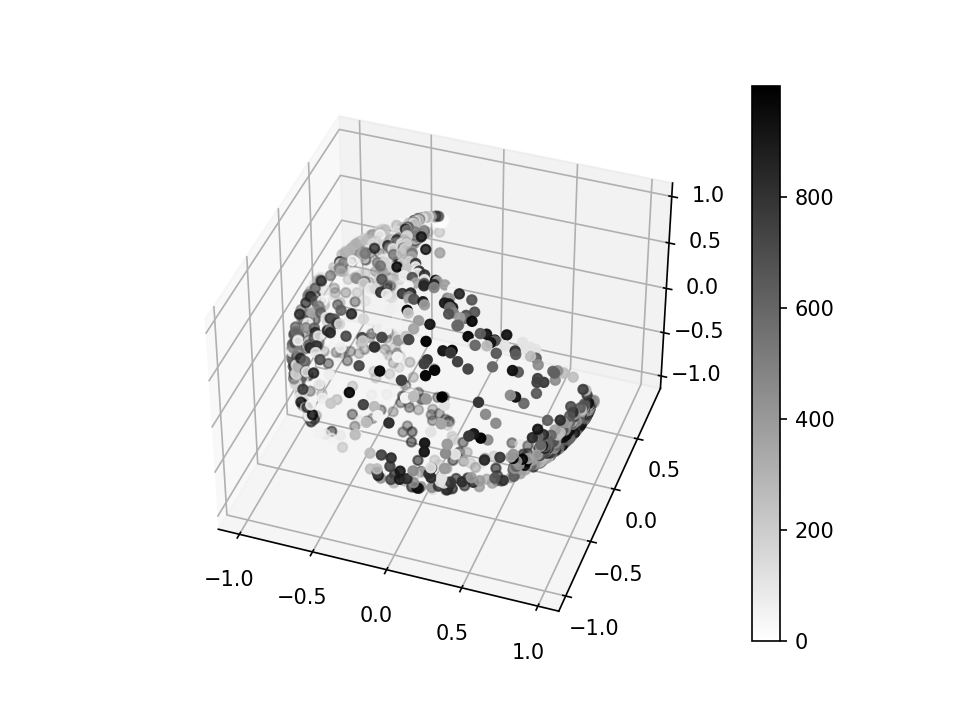

In [28]:
morphIdx = 5
state_size = states[morphIdx].shape[-1]
g = env[morphIdx].get_graph()._get_dgl_graph().cpu()

episode_idx = 2
episode_states = torch.from_numpy(states[morphIdx][episode_idx * 1000: (episode_idx+1) * 1000])
encodings = encoderGNN(g, episode_states).detach().cpu().numpy()

num_nodes, batch_size, num_latents = encodings.shape

x = encodings[0, :, 0]
y = encodings[0, :, 1]
z = encodings[0, :, 2]


random_idx = np.random.choice(np.arange(1000))
randomly_chosen_state = episode_states[random_idx]
state_pairs = randomly_chosen_state.unsqueeze(0).repeat(1000, 2)
state_pairs[:,  state_size:] -= episode_states
prediction_sigmoids = inverseDynamics(g, state_pairs).detach().cpu().numpy()

indeces_to_keep = prediction_sigmoids > 0.5
prediction_sigmoids = prediction_sigmoids[indeces_to_keep]
origin_point = encodings[:, random_idx]
kept_encodings = encodings[:, indeces_to_keep]


c = np.arange(batch_size)

cmap = 'binary'

ax = plt.axes(projection ='3d')
ax.scatter3D(x, y, z, c=c, cmap=cmap)

normalize = mcolors.Normalize(vmin=c.min(), vmax=c.max())
scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=cmap)
scalarmappaple.set_array(c)
plt.colorbar(scalarmappaple)

plt.show()

tensor(1.3414, dtype=torch.float64)


<IPython.core.display.Javascript object>


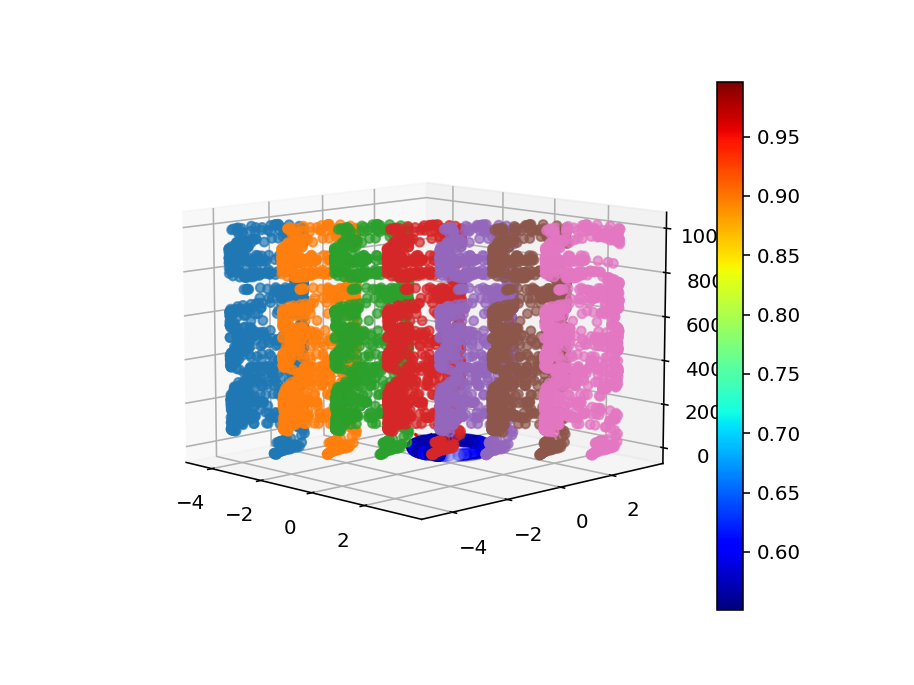

In [65]:
morphIdx = 5
g = env[morphIdx].get_graph()._get_dgl_graph().cpu()
original_states = torch.from_numpy(states[morphIdx][0:1000])
with torch.no_grad():
    encodings = encoderGNN(g, original_states)
    decoded_states = decoderGNN(g, encodings)

reconstructed_states = reconstructStateFromGraph(decoded_states)
mseLoss = torch.nn.MSELoss()
print(mseLoss(original_states, reconstructed_states))


shiftAmount = 1

numNodes, batchSize, latentSize = encodings.shape
fig = plt.figure() 
z = np.arange(batchSize)
# syntax for 3-D projection 
ax = plt.axes(projection ='3d') 


for nodeIdx in range(numNodes):

    xy_shift = (- numNodes / 2 + nodeIdx) * shiftAmount
    # defining all 3 axes 
    x = np.array(encodings[nodeIdx, :, 0]) + xy_shift
    y = np.array(encodings[nodeIdx, :, 1]) + xy_shift

    # plotting 
    ax.scatter3D(x, y, z, alpha=0.7)
    
# ax.set_xlabel('Latent Variable 0 (Shifted)')
# ax.set_ylabel('Latent Variable 1 (Shifted)')
# ax.set_zlabel('X Velocity')
# ax.set_title('Latent Space Variables over Episode Step for all Nodes')
# ax.legend(['Node ' + str(x) for x in range(numNodes)])

# ax.view_init(elev=0, azim=45)
# fig.savefig('{}-latentVis-1.png'.format(morphIdx))

# ax.view_init(elev=30, azim=90)
# fig.savefig('{}-latentVis-2.png'.format(morphIdx))


# ax.view_init(elev=15, azim=0)
# fig.savefig('{}-latentVis-3.png'.format(morphIdx))

# ax.view_init(elev=90, azim=0)
# fig.savefig('{}-latentVis-4.png'.format(morphIdx))

plt.show()

In [61]:
morphIdx = 5
max_vel = states[morphIdx][:, 0].max()
min_vel = states[morphIdx][:, 0].min()
num_samples = 2048
state_space = states[morphIdx][0].shape[0]
offsets = torch.from_numpy(np.linspace(start=min_vel, stop=max_vel, num=num_samples))
# offsets = torch.from_numpy(np.linspace(start=-2, stop=2, num=num_samples))
randomly_sampled_state = torch.from_numpy(states[morphIdx][0][np.newaxis, ...].repeat(repeats=num_samples, axis=0))
randomly_sampled_state[:, 0] = offsets

<IPython.core.display.Javascript object>


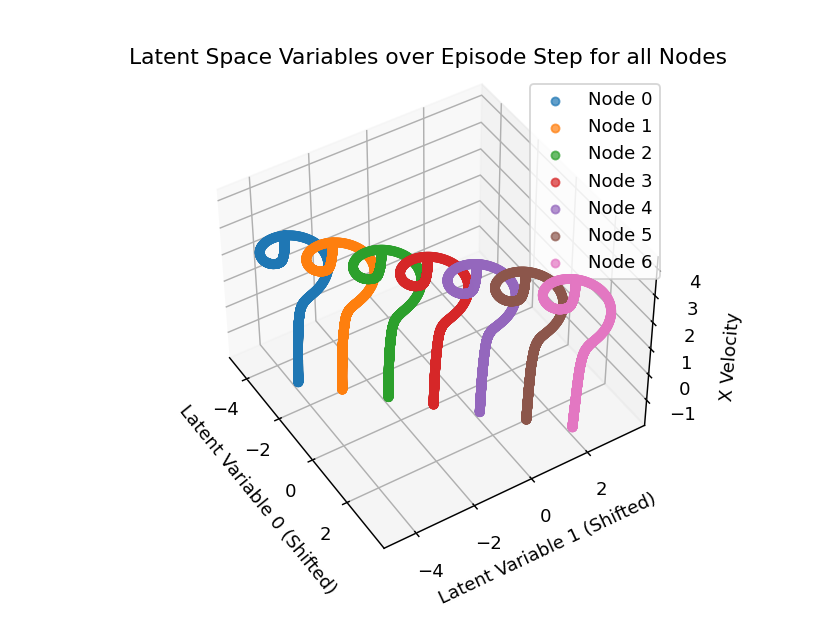

In [62]:
g = env[morphIdx].get_graph()._get_dgl_graph().cpu()
encodings = encoderGNN(g, randomly_sampled_state).to('cpu').detach().numpy()

shiftAmount = 1

numNodes, batchSize, latentSize = encodings.shape
fig = plt.figure() 
z = np.linspace(start=min_vel, stop=max_vel, num=num_samples)
# syntax for 3-D projection 
ax = plt.axes(projection ='3d') 


for nodeIdx in range(numNodes):

    xy_shift = (- numNodes / 2 + nodeIdx) * shiftAmount
    # defining all 3 axes 
    x = np.array(encodings[nodeIdx, :, 0]) + xy_shift
    y = np.array(encodings[nodeIdx, :, 1]) + xy_shift

    # plotting 
    ax.scatter3D(x, y, z, alpha=0.7)
    
ax.set_xlabel('Latent Variable 0 (Shifted)')
ax.set_ylabel('Latent Variable 1 (Shifted)')
ax.set_zlabel('X Velocity')
ax.set_title('Latent Space Variables over Episode Step for all Nodes')
ax.legend(['Node ' + str(x) for x in range(numNodes)])

ax.view_init(elev=0, azim=45)
fig.savefig('{}-latentVis-1.png'.format(morphIdx))

ax.view_init(elev=30, azim=90)
fig.savefig('{}-latentVis-2.png'.format(morphIdx))


ax.view_init(elev=15, azim=0)
fig.savefig('{}-latentVis-3.png'.format(morphIdx))

ax.view_init(elev=90, azim=0)
fig.savefig('{}-latentVis-4.png'.format(morphIdx))

plt.show()

In [108]:
alpha = 0.1
size = 10000
n = 3 # or any positive integer
a = np.random.normal(size=(size, n)) 
a /= np.linalg.norm(a, axis=-1)[:, np.newaxis]
a *= np.random.uniform(low=0, high=alpha, size=size)[:, np.newaxis]

In [109]:
p = np.random.normal(size=3)[np.newaxis, :]
p /= np.linalg.norm(p, axis=-1)
p = np.repeat(p, size, axis=0)

In [110]:
new_points = p - a
new_points /= np.linalg.norm(new_points, axis=-1)[:, np.newaxis]

In [111]:
new_distances = np.linalg.norm(p - new_points, axis=-1)

In [112]:
print(np.mean(new_distances <= alpha))

0.9998


In [59]:
np.linalg.norm(new_points, axis=-1)

array([1.00004886e+00, 1.00460035e+00, 9.72878187e-01, 9.27029693e-01,
       9.13485686e-01, 9.54528945e-01, 1.00614099e+00, 1.02640725e+00,
       1.00305424e+00, 9.62438378e-01, 8.97054616e-01, 1.00910705e+00,
       8.32993747e-01, 1.06003914e+00, 1.00725955e+00, 8.79941637e-01,
       1.36614050e+00, 1.00547159e+00, 1.10915494e+00, 9.37840852e-01,
       9.13817607e-01, 1.01607374e+00, 1.03136467e+00, 2.43289015e+00,
       1.02764930e+00, 8.74418203e-01, 9.87220360e-01, 1.71519106e+00,
       1.52979928e+00, 9.95225683e-01, 1.00374367e+00, 9.08939632e-01,
       9.01117844e-01, 1.05413479e+00, 1.00996141e+00, 9.77370664e-01,
       9.64126120e-01, 2.87045691e+00, 9.53566152e-01, 9.96885784e-01,
       8.96736398e-01, 9.79594665e-01, 1.03614891e+00, 1.02776739e+00,
       1.87553383e+00, 1.29826491e+00, 9.25795046e-01, 9.20069276e-01,
       3.06908442e+00, 9.36289820e-01, 1.00686290e+00, 9.49359896e-01,
       1.00303375e+00, 1.02272425e+00, 9.99653780e-01, 1.05454309e+00,
      

<IPython.core.display.Javascript object>


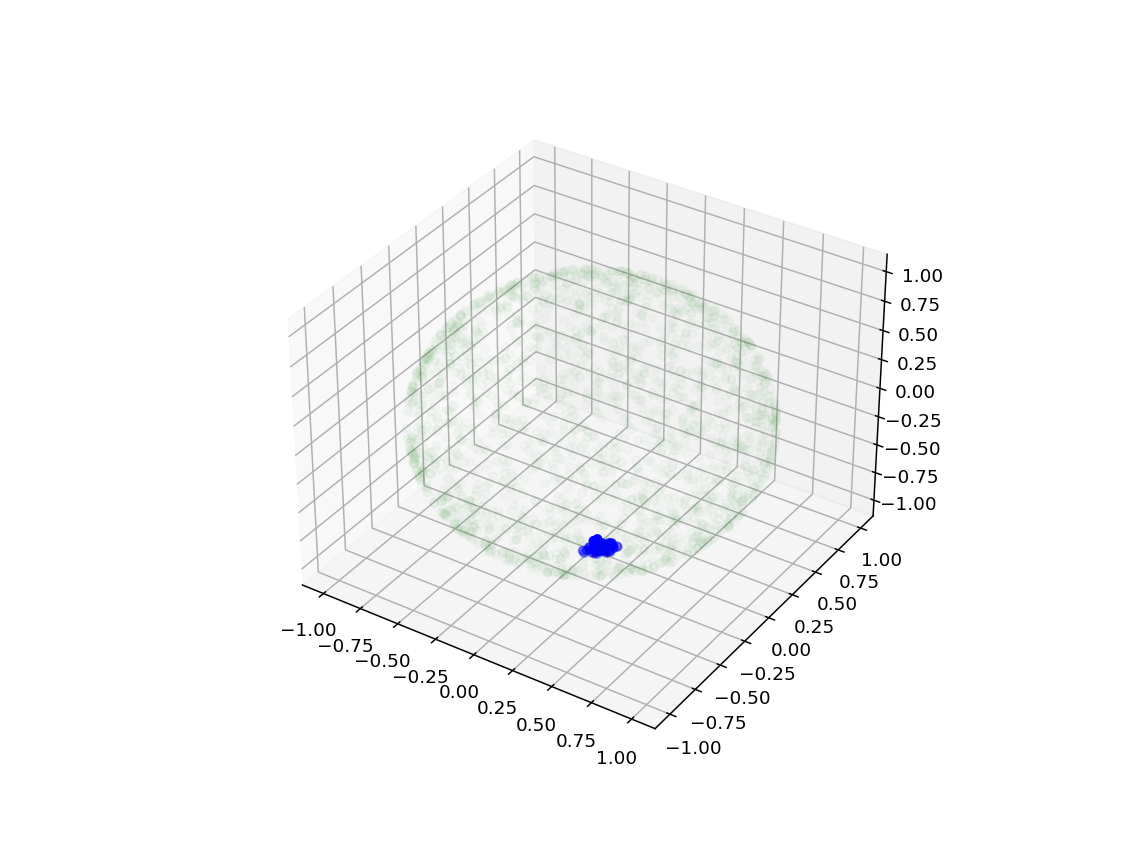

In [115]:
fig = plt.figure()

# Randomly sample points on sphere, only included for ilustration purposes
num_base_points = 2048
base_sphere_points = np.random.normal(size=(num_base_points, 3))
base_sphere_points /= np.linalg.norm(base_sphere_points, axis=-1)[:, np.newaxis]

# Define target point
random_point = base_sphere_points[np.random.choice(num_base_points)]

# Randomly sample within alpha distance of point (i.e. within the sphere with centre base point and radius alpha)
alpha = 0.1
num_offsets = 100
offsets = np.random.normal(size=(num_offsets, 3)) 
offsets /= np.linalg.norm(offsets, axis=-1)[:, np.newaxis]
offsets *= np.random.uniform(low=0, high=alpha, size=num_offsets)[:, np.newaxis]

# Convert coordinates from sphere into global ones, and project onto original sphere
new_points = random_point - offsets
new_points /= np.linalg.norm(new_points, axis=-1)[:, np.newaxis]

ax = plt.axes(projection ='3d') 
ax.scatter3D(base_sphere_points[:, 0], base_sphere_points[:, 1], base_sphere_points[:,2], c='green', alpha=0.02)
ax.scatter3D(random_point[0], random_point[1], random_point[2], c='red', marker='x', s=80)
ax.scatter3D(new_points[:, 0], new_points[:, 1], new_points[:,2], c='blue')
plt.show()

In [18]:
def fibonacci_sphere(samples=1):

    points = []
    phi = math.pi * (3. - math.sqrt(5.))  # golden angle in radians

    for i in range(samples):
        y = 1 - (i / float(samples - 1)) * 2  # y goes from 1 to -1
        radius = math.sqrt(1 - y * y)  # radius at y

        theta = phi * i  # golden angle increment

        x = math.cos(theta) * radius
        z = math.sin(theta) * radius

        points.append((x, y, z))

    return np.array(points)

In [248]:
num_points = 75

closest_neighbors = []
for i in range(5000):
    
    points = fibonacci_sphere(num_points)
    rand_index = np.random.choice(np.arange(num_points))
    dist = sorted(np.sqrt(np.sum((points - points[rand_index]) ** 2, axis=-1)))
    closest_neighbors.append((dist[1], dist[2], dist[3], dist[4]))
closest_neighbors = np.array(closest_neighbors)

<IPython.core.display.Javascript object>


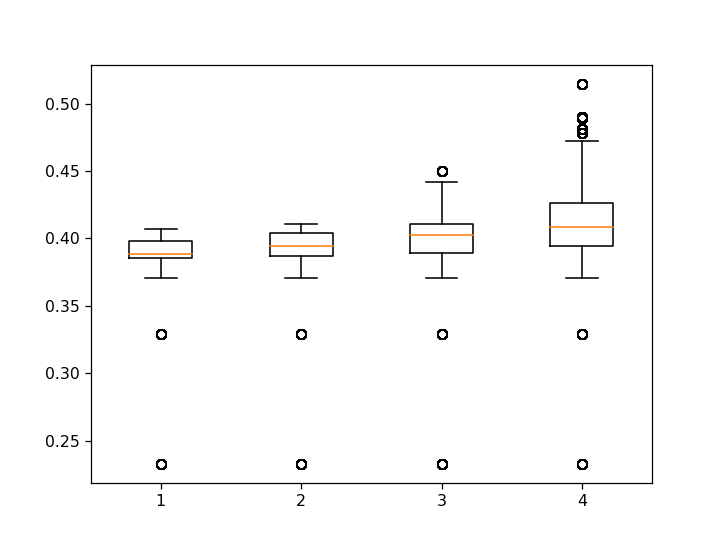

In [249]:
data1 = closest_neighbors[:, 0]
data2 = closest_neighbors[:, :2].flatten()
data3 = closest_neighbors[:, :3].flatten()
data4 = closest_neighbors[:, :4].flatten()

data = [data1, data2, data3, data4]

# Creating axes instance
# ax = fig.add_axes([0, 0, 1, 1])

fig = plt.figure()

plt.boxplot(data)
fig.show()

In [209]:
print(np.mean(closest_neighbors[:,0]-closest_neighbors[:,1]))
print(np.mean(closest_neighbors[:,0]))
print(np.std(closest_neighbors[:, 0]))

-0.016515554673292306
0.3803151317809595
0.04044778659121944


<IPython.core.display.Javascript object>


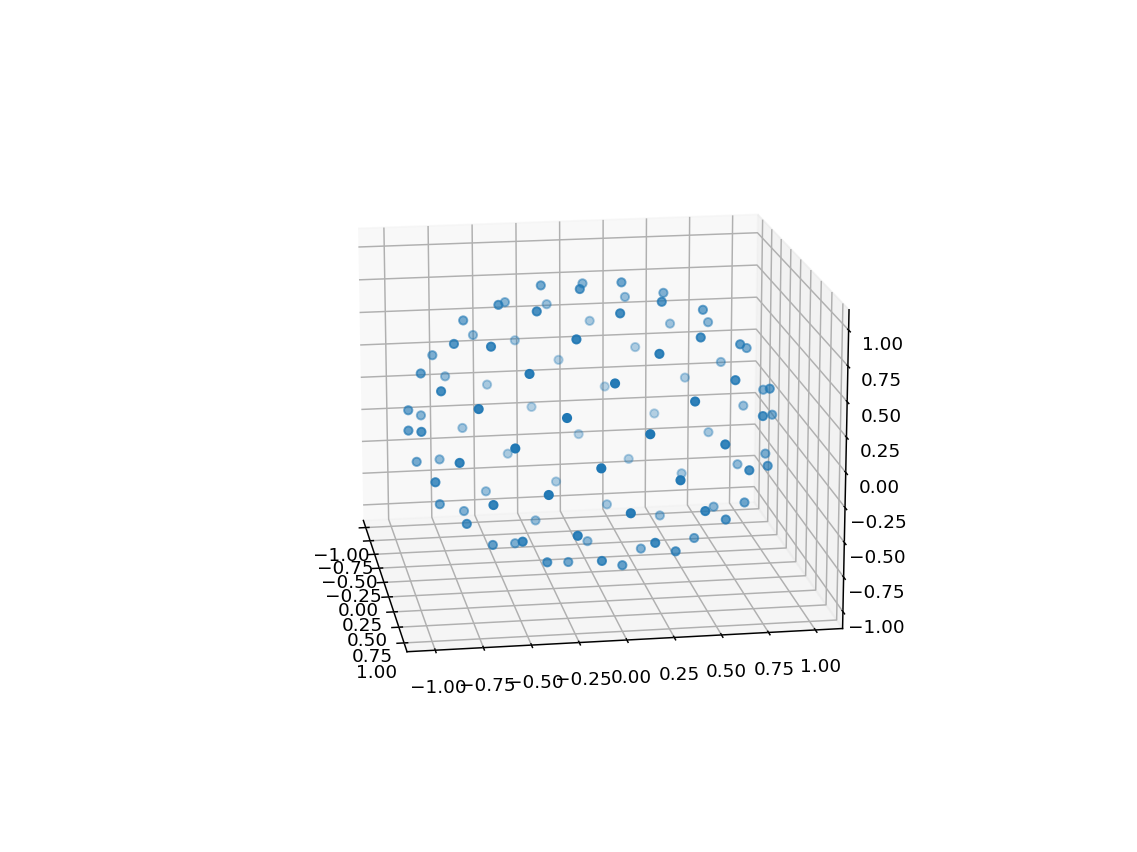

In [192]:
fig = plt.figure()

ax = plt.axes(projection ='3d') 
ax.scatter3D(points[:, 0], points[:, 1], points[:,2])
plt.show()